In [19]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import pdb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import torch.optim as optim
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import IPython.display as ipd

## Load audio and plot

In [15]:
def load_audio_file(file_path):
    input_length = 16000
    data = librosa.core.load(file_path)[0] #, sr=16000
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data
def plot_time_series(data):
    fig = plt.figure(figsize=(8, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()

# Preprocessing

## Data augmentation

Adding white noise

In [20]:
# Adding white noise 
def addNoise(data):
  wn = np.random.randn(len(data))
  data_wn = data + 0.005*wn
  plot_time_series(data_wn)

  ipd.Audio(data_wn, rate=16000)
  return data_wn

In [21]:
audiofile=load_audio_file('bad.wav')

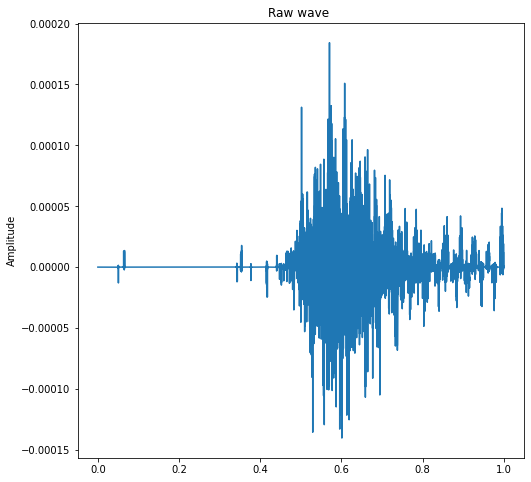

In [22]:
plot_time_series(audiofile)

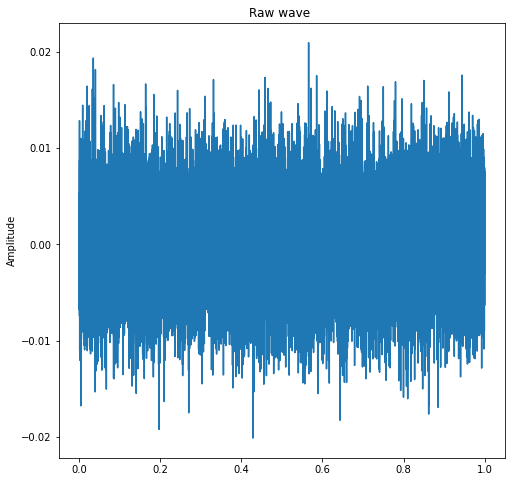

array([-0.00029174, -0.00174163, -0.00442374, ...,  0.00467844,
       -0.00235881,  0.00752379])

In [23]:
addNoise(audiofile)

shifting the sound

In [ ]:
# Shifting the sound
def shifting(data):
  data_roll = np.roll(data, 1600)
  plot_time_series(data_roll)
  ipd.Audio(data_roll, rate=16000)
  return data_roll

stretching the sound

In [ ]:
# stretching the sound
def stretch(data, rate=1):
    input_length = 16000
    data = librosa.effects.time_stretch(data, rate)
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

    return data


data_stretch =stretch(data, 0.8)
print("This makes the sound deeper but we can still hear 'off' ")
plot_time_series(data_stretch)
ipd.Audio(data_stretch, rate=16000)

data_stretch =stretch(data, 1.2)
print("Higher frequencies  ")
plot_time_series(data_stretch)
ipd.Audio(data_stretch, rate=16000)

# Extract Features

In [ ]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        print(sample_rate)
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            stft=np.abs(librosa.stft(X))
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        zcrs = librosa.feature.zero_crossing_rate(x + 0.0001)
        result=np.hstack((result, mel))
    return result

In [ ]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature1(X, mfcc, chroma, mel,sample_rate):
    #with soundfile.SoundFile(file_name) as sound_file:
        #X = sound_file.read(dtype="float32")
        #sample_rate=sound_file.samplerate      
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma:
        stft=np.abs(librosa.stft(X))
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel:
        mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
    return result

# emotions dictionary

In [ ]:
#Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'happy', 'fearful','angry', 'disgust','surprised','sad','neutral']

good_emotion=['neutral','calm','happy']
medium_emotion=['sad','disgust']
bad_emotion=['angry','fearful','surprised']

# Load dataset

In [ ]:
#DataFlair - Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    # Place the path of the data 
    for file in glob.glob(""):
        file_name=os.path.basename(file)
        #print(file_name)
        emotion = os.path.basename(os.path.dirname(file))
        #print(emotion)
        #emotion=emotions[file_name.split("-")[2]]
        #if emotion not in observed_emotions:
        #    continue
        y1, s = librosa.load(file)
        #print(s)
        if emotion in good_emotion:
            feature=extract_feature1(X=y1, mfcc=True, chroma=True, mel=True,sample_rate=s)
            #feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
            x.append(feature)
            y.append('good')
        elif emotion in bad_emotion:
            #feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
            feature=extract_feature1(X=y1, mfcc=True, chroma=True, mel=True,sample_rate=s)
            x.append(feature)
            y.append('bad')
        elif emotion in medium_emotion:
            feature=extract_feature1(X=y1, mfcc=True, chroma=True, mel=True,sample_rate=s)
            x.append(feature)
            y.append('medium')
        #feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        #x.append(feature)
        #y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

# Split the dataset

In [ ]:
x_train,x_test,y_train,y_test = load_data(test_size=0.25)

# Observe the shapes

In [ ]:
#Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

# Model

# Tuning hyper parameters

In [ ]:
# hyper parameters
alpha=0.001
batch_size=200
epsilon=1e-10
hidden_layer_sizes=(300,)
learning_rate='adaptive'
max_iter=200

# Training 

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=alpha, 
                    batch_size=batch_size, 
                    epsilon=epsilon, 
                    hidden_layer_sizes=hidden_layer_sizes, 
                    learning_rate=learning_rate, 
                    max_iter=max_iter)

In [ ]:
model.fit(x_train, y_train)

# predict on the test set

In [ ]:
# Predict for the test set
y_pred=model.predict(x_test)

In [1]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 93.00%


In [ ]:
confusion_matrix=confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[502  29  16]
 [ 25 389  11]
 [ 32  30 279]]


In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         bad       0.90      0.92      0.91       547
        good       0.87      0.92      0.89       425
      medium       0.91      0.82      0.86       341

    accuracy                           0.89      1313
   macro avg       0.89      0.88      0.89      1313
weighted avg       0.89      0.89      0.89      1313



# test on your own data

In [ ]:
x=[]
y=[]
file="examples/nada-neutral2.wav"
y, s = librosa.load(file) # Downsample 44.1kHz to 8kHz

feature=extract_feature1(X=y, mfcc=True, chroma=True, mel=True,sample_rate=s)
#feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
x.append(feature)

In [ ]:
s

22050

In [ ]:
y_pred=model.predict(x)

In [ ]:
y_pred

array(['medium'], dtype='<U6')

In [ ]:
model.predict_proba(x)

array([[2.87435904e-02, 6.15118526e-13, 9.71256410e-01]])

In [ ]:
model

MLPClassifier(activation='relu', alpha=0.0001, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-09,
              hidden_layer_sizes=(400,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [ ]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

In [ ]:
model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
x=[]
y=[]
file="examples/nada-neutral2.wav"
y, s = librosa.load(file) # Downsample 44.1kHz to 8kHz

feature=extract_feature1(X=y, mfcc=True, chroma=True, mel=True,sample_rate=s)
x.append(feature)

In [ ]:
y_pred=model.predict(x)

In [ ]:
y_pred

array(['medium'], dtype='<U6')

## Neural Network

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        super().__init__()
        
        self.inplanes = 64
        #conv block 
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 4 layers, earch of which composed of multiple resuidal blocks. 
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        #classifier layer 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 , num_classes)


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None  
   
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, 1, stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        
        self.inplanes = planes
        
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)           # 224x224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)         # 112x112

        x = self.layer1(x)          # 56x56
        x = self.layer2(x)          # 28x28
        x = self.layer3(x)          # 14x14
        x = self.layer4(x)          # 7x7

        x = self.avgpool(x)         # 1x1
        x = torch.flatten(x, 1)     # remove 1 X 1 grid and make vector of tensor shape 
        x = self.fc(x)

        return x

In [ ]:
def resnet34():
    layers=[3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

In [ ]:
model = resnet34()

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root='./RAVDESS2', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.ImageFolder(root='./RAVDESS2', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('Good','Bad')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
print(images.size())
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
y,s = librosa.load('bad.wav')

In [25]:
mfccs=np.mean(librosa.feature.mfcc(y=y, sr=s, n_mfcc=40).T, axis=0)


In [28]:
stft=np.abs(librosa.stft(y))

In [29]:
chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=s).T,axis=0)

In [30]:
chroma

array([0.64178616, 0.7030627 , 0.72929114, 0.7663088 , 0.7129627 ,
       0.66344166, 0.6573323 , 0.6432687 , 0.6322239 , 0.70637465,
       0.72381604, 0.6615041 ], dtype=float32)